In [1]:
import os

import climlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py/cm-v6"
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
fp_ulwrf = f"{DATASETS_DIR}/ulwrf.ntat.mon.1981-2010.ltm.nc"
fp_dswrf = f"{DATASETS_DIR}/dswrf.ntat.mon.1981-2010.ltm.nc"
fp_uswrf = f"{DATASETS_DIR}/uswrf.ntat.mon.1981-2010.ltm.nc"

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath, decode_times=xr.coders.CFDatetimeCoder(use_cftime=True)
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
)
ncep_ulwrf = download_and_save_dataset(
    ncep_url + "other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc",
    fp_ulwrf,
    "NCEP upwelling longwave radiation",
)
ncep_dswrf = download_and_save_dataset(
    ncep_url + "other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc",
    fp_dswrf,
    "NCEP downwelling shortwave radiation",
)
ncep_uswrf = download_and_save_dataset(
    ncep_url + "other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc",
    fp_uswrf,
    "NCEP upwelling shortwave radiation",
)

Loading NCEP surface temperature data ...
Loading NCEP upwelling longwave radiation data ...
Loading NCEP downwelling shortwave radiation data ...
Loading NCEP upwelling shortwave radiation data ...


In [3]:
lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=("lon", "time"))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(
    dim=("lon", "time")
)

In [4]:
A = 210
B = 2
a0 = 0.354
a2 = 0.25

In [5]:
Darray = np.arange(0.0, 2.05, 0.05)
nSteps = 200
nMonthDays = 30.0

In [6]:
data = []

for D in tqdm.tqdm(Darray):
    ebm = climlab.EBM_annual(
        A=A, B=B, a0=a0, a2=a2, D=D, num_lat=len(lat_ncep)
    )
    for i in range(nSteps):
        ebm.integrate_days(nMonthDays, verbose=False)
    Tmean = ebm.global_mean_temperature()
    deltaT = np.max(ebm.Ts) - np.min(ebm.Ts)
    energy_in = np.squeeze(ebm.ASR - ebm.OLR)
    Htrans = ebm.heat_transport
    data.append(
        {
            "d": D,
            "model": ebm,
            "Tmean": Tmean,
            "deltaT": deltaT,
            "Hmax": np.max(Htrans),
        }
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:33<00:00,  1.21it/s]


In [7]:
data = pd.DataFrame(data)

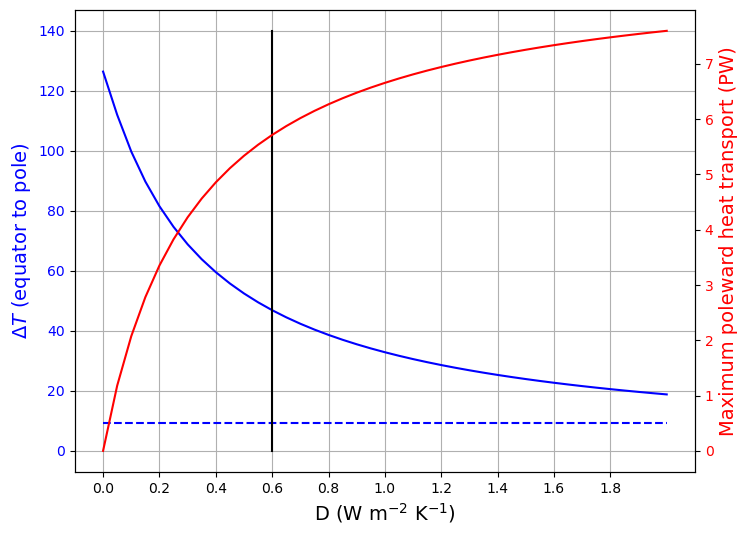

In [8]:
color1 = "b"
color2 = "r"

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(Darray, data["deltaT"], color=color1)
ax1.plot(Darray, data["Tmean"], "b--")
ax1.set_xlabel("D (W m$^{-2}$ K$^{-1}$)", fontsize=14)
ax1.set_xticks(np.arange(Darray[0], Darray[-1], 0.2))
ax1.set_ylabel("$\Delta T$ (equator to pole)", fontsize=14, color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax2 = ax1.twinx()
ax2.plot(Darray, data["Hmax"], color=color2)
ax2.set_ylabel(
    "Maximum poleward heat transport (PW)", fontsize=14, color=color2
)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.grid()

ax1.plot([0.6, 0.6], [0, 140], "k-");

In [9]:
D, model, Tmean, deltaT, Hmax = data[
    (data["d"] > 0.55) & (data["d"] < 0.65)
].values[0]

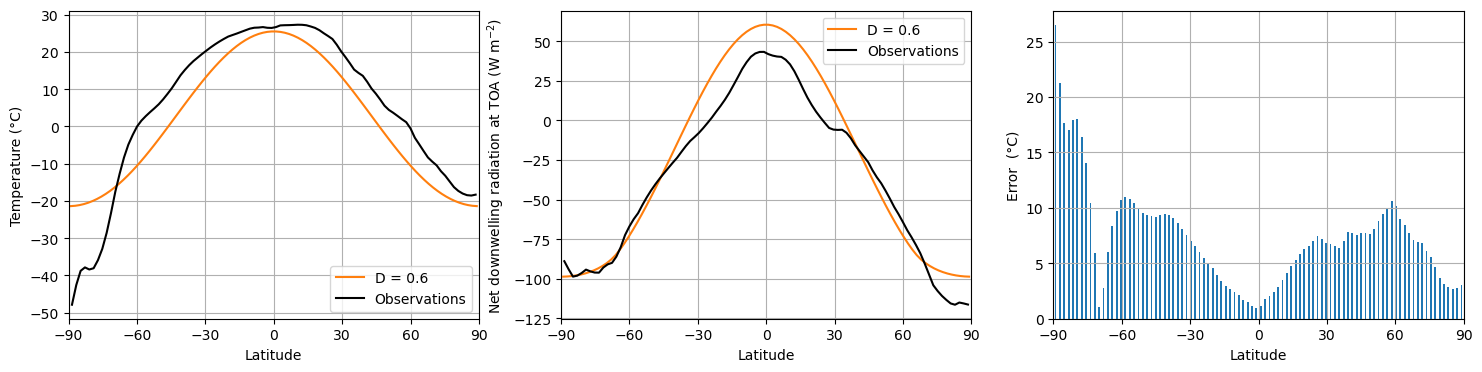

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.plot(model.lat, model.Ts, label=("D = %0.1f" % D), c="#ff7f0e")
ax.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

ax = axes[1]
energy_in = np.squeeze(model.ASR - model.OLR)
ax.plot(model.lat, energy_in, label=("D = %0.1f" % D), c="#ff7f0e")
ax.plot(
    lat_ncep, ASR_ncep_annual - OLR_ncep_annual, label="Observations", c="k"
)
ax.set_ylabel("Net downwelling radiation at TOA (W m$^{-2}$)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

ax = axes[2]
ax.bar(
    x=model.lat,
    height=np.abs(model.Ts.reshape(-1) - Ts_ncep_annual.values[::-1]),
)
ax.set_ylabel("Error  (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.grid()

plt.show()

In [11]:
mse = np.mean(
    (np.array(model.Ts.reshape(-1)) - Ts_ncep_annual.values[::-1])[15:-15] ** 2
)
mse

50.35837594144805